# How To Upsample and Coarse Dropout with TFRecords
In this notebook, we present a template for performing multiple experiments on the same KFold fold. Afterward we can compare validation scores. Or we can repeat the same experiment over and over to assess validation score variability.

We will explore **upsampling** and **coarse dropout** with TFRecords. When using a dataloader it would be a simple job of returning more minority samples and using Albumentations for augmentation. With TFRecords, it is different. We must write more TF code and make more TFRecords.

## Coarse dropout
* Coarse dropout is a data augmentation technique to prevent your model from overfitting. We randomly remove squares from training images. (Discussion [here][1]).
![dropout](http://playagricola.com/Kaggle/drop-7-24.jpg)

## Upsampling 
* Upsampling (oversampling) is a technique to help your model learn the minority class by adding more examples of the minority. Alternatively, we can downsample (undersample) but then we would have less training data. (Discussion [here][2]).
![dropout](http://playagricola.com/Kaggle/up-7-24.png)

[1]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/169721
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/169139

# Initialize Environment

In [1]:
!pip install -q efficientnet >> /dev/null

import pandas as pd, numpy as np, gc
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

## Configuration
First we choose a number of `EXPERIMENTS`. Then this notebook will perform that many experiments on the same KFold fold. Afterward we can compare validation scores. Or you can repeat the same experiment many times and assess validation score variability. If you have read my previous notebook [here][1], you are familar with most of these configuration variables. We will list the new parameters first:

### New Variables
* EXPERIMENTS - number of experiments to perform
* FNUMBER - which of the KFolds to repeatedly perform experiments on. 
* M1 - is a list of length EXPERIMENTS. For each experiment, choose 0, 1, 2, 3, etc. Determines how many additional copies of malignant images from this years comp data to add
* M2 - is a list. Adds copies of malignant images from ISIC archive that are not in 2020, 2019, 2018, 2017 comp data
* M3 - is a list. Adds copies of malignant images from 2019 comp data. They have been filtered to include the ones that look like 2020 data
* M4 - is a list. Adds copies of malignant images from 2018 2017 data.
* DROP_FREQ - a list of floats between 0 and 1. Determines proportion of train images to apply coarse dropout to
* DROP_CT - a list of ints. How many squares to remove from train images when applying dropout. (Note that if you use CT>16 with FREQ=1, it may slow down training when using small image resolutions like 128x128 if your CPU is slow).
* DROP_SIZE - a list of floats between 0 and 1. The size of square side equals `IMG_SIZE * DROP_SIZE`
* INFER_TEST - whether to predict test images each experiment

### Old Variables
* DEVICE - is GPU or TPU
* SEED and FOLDS - a different seed produces a different validation hold out set.
* IMG_SIZES - is a list of length EXPERIMENTS. These are the image sizes to use each experiment
* INC2019 - is a list of 0s and 1s. This includes the new half of the 2019 competition data. The second half of the 2019 data is the comp data from 2018 plus 2017
* INC2018 - is a list of 0s and 1s. This includes the second half of the 2019 competition data which is the comp data from 2018 plus 2017
* BATCH_SIZES - is a list of length EXPERIMENTS. These are batch sizes for each experiment. For maximum speed, it is best to use the largest batch size your GPU or TPU allows.
* EPOCHS - is a list of length EXPERIMENTS. These are maximum epochs. Note that each experiment, the best epoch model is saved and used. So if epochs is too large, it won't matter.
* EFF_NETS - is a list of length EXPERIMENTS. These are the EfficientNets to use each experiment. The number refers to the B. So a number of `0` refers to EfficientNetB0, and `1` refers to EfficientNetB1, etc.
* WGTS - this should be `1/EXPERIMENTS` for each experiment. This is the weight when ensembling the experiments to predict the test set.
* TTA - test time augmentation. Each validation image is randomly augmented and predicted TTA times and the average prediction is used. TTA is also applied to test images during test prediction.

[1]: https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords

In [2]:
DEVICE = "GPU" #or "TPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42; FOLDS = 5

# WHICH FOLD TO PERFORM EXPERIMENTS ON
FNUMBER = 3; EXPERIMENTS = 3

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [128]*EXPERIMENTS

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [0]*EXPERIMENTS
INC2018 = [1]*EXPERIMENTS

# UPSAMPLE MALIGNANT COUNT TIMES
M1 = [0,0,1] #2020 malig
M2 = [0,0,1] #ISIC malig
M3 = [0,0,1] #2019 good malig
M4 = [0,0,1] #2018 2017 malig

# COARSE DROPOUT
DROP_FREQ = [0,0.75,0.75] # between 0 and 1
DROP_CT = [0,8,8] # may slow training if CT>16
DROP_SIZE = [0,0.2,0.2] # between 0 and 1

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [32]*EXPERIMENTS
EPOCHS = [20]*EXPERIMENTS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [0]*EXPERIMENTS

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/EXPERIMENTS]*EXPERIMENTS

# TEST TIME AUGMENTATION STEPS
TTA = 11
INFER_TEST = True

In [3]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


# Step 1: Preprocess
Preprocess has already been done and saved to TFRecords. Here we choose which size to load. We can use either 128x128, 192x192, 256x256, 384x384, 512x512, 768x768 by changing the `IMG_SIZES` variable in the preceeding code section. These TFRecords are discussed [here][1]. The advantage of using different input sizes is discussed [here][2]

[1]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/155579
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147

In [4]:
GCS_PATH = [None]*FOLDS; GCS_PATH2 = [None]*FOLDS; GCS_PATH3 = [None]*FOLDS
for i,k in enumerate(IMG_SIZES[:FOLDS]):
    GCS_PATH[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
    GCS_PATH2[i] = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(k,k))
    GCS_PATH3[i] = KaggleDatasets().get_gcs_path('malignant-v2-%ix%i'%(k,k))
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))

# Step 2: Data Augmentation
Below is TensorFlow code to perform coarse dropout data augmentation on `tf.data.Dataset()`. (Also below is code to perform rotation, sheer, zoom, shift, and color adjustments). Rotation, sheer, zoom, shift augmentation first shown in this notebook [here][1] and successfully used in Melanoma comp by AgentAuers [here][2]. 

Additionally we can decide to use external data by changing the variables `INC2019` and `INC2018` in the preceeding code section. These variables respectively indicate whether to load last year 2019 data and/or year 2018 + 2017 data. These datasets are discussed [here][3]

Consider experimenting with different augmenation and/or external data. The code to load TFRecords is taken from AgentAuers' notebook [here][2]. Thank you AgentAuers, this is great work.

[1]: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
[2]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once
[3]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/164910

In [5]:
ROT_ = 180.0; SHR_ = 2.0
HZOOM_ = 8.0; WZOOM_ = 8.0
HSHIFT_ = 8.0; WSHIFT_ = 8.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [6]:
def dropout(image, DIM=256, PROBABILITY = 0.75, CT = 8, SZ = 0.2):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
    image = tf.reshape(image,[DIM,DIM,3])
    return image

In [7]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name=True):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, augment=True, dim=256, droprate=0, dropct=0, dropsize=0):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        if (droprate!=0)&(dropct!=0)&(dropsize!=0): 
            img = dropout(img, DIM=dim, PROBABILITY=droprate, CT=dropct, SZ=dropsize)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [8]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256,
                droprate=0, dropct=0, dropsize=0):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*2) #if too large causes OOM in GPU CPU
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (
                prepare_image(img, augment=augment, dim=dim, 
                              droprate=droprate, dropct=dropct, dropsize=dropsize), 
                imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

## Display Data Augmentation
By displaying our data augmentation, this allows us to adjust the parameters until it display to our liking. We will apply lots of dropout to challenge our model and encourage generalization to unseen images. (Code for displaying augmentation is taken from AgentAuers' notebook [here][1]).

[1]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once

In [9]:
import PIL, cv2

def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))
        nn = target_or_imgid.numpy().decode("utf-8")

    display(mosaic)
    return nn

WITH DROPOUT AUGMENTATION - dropout_freq=0.75 count=8 size=0.200


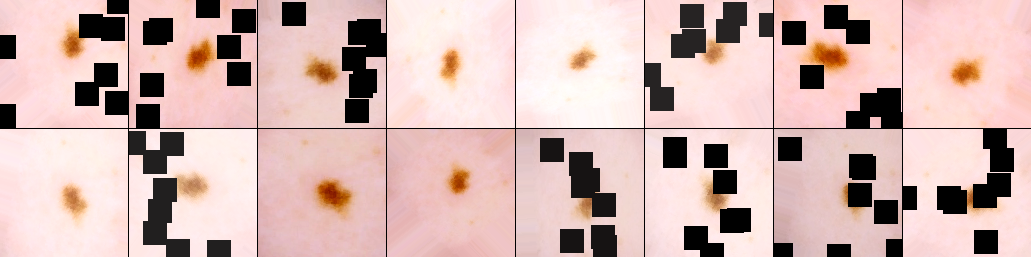

WITHOUT AUGMENTATION - Original Image


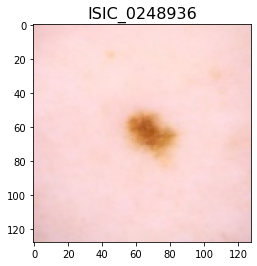

In [10]:
PATH9 =  '../input/jpeg-melanoma-128x128/train/'
files_train = tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')

# DROPOUT parameters to display
RATE = 0.75; CT = 8; SIZE = 0.2

# LOAD DATA AND APPLY AUGMENTATIONS
ds = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO).shuffle(1024)
ds = ds.take(1).cache().repeat()

ds = ds.map(read_unlabeled_tfrecord, num_parallel_calls=AUTO)
ds = ds.map(lambda img, target: (prepare_image(img, augment=True, dim=IMG_SIZES[0],
            droprate = RATE, dropct = CT, dropsize = SIZE
            ), target), num_parallel_calls=AUTO)
ds = ds.take(12*5); ds = ds.prefetch(AUTO)

# DISPLAY IMAGE WITH AND WITHOUT AUGMENTATIONS
print('WITH DROPOUT AUGMENTATION - dropout_freq=%.2f count=%i size=%.3f'%(RATE,CT,SIZE))
name = show_dataset(128, 8, 2, ds)
img = cv2.imread(PATH9+name+'.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

print('WITHOUT AUGMENTATION - Original Image')
plt.title('%s'%name,size=16); plt.show()

# Step 3: Build Model
This is a common model architecute. Consider experimenting with different backbones, custom heads, losses, and optimizers. Also consider inputing meta features into your CNN.

In [11]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]

def build_model(dim=128, ef=0):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

# Step 4: Train Schedule
This is a common train schedule for transfer learning. The learning rate starts near zero, then increases to a maximum, then decays over time. Consider changing the schedule and/or learning rates. Note how the learning rate max is larger with larger batches sizes. This is a good practice to follow.

In [12]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

# Train Experiments
In this notebook we run 3 experiments.
* Experiment 1 - baseline
* Experiment 2 - add dropout
* Experiment 3 - add dropout and upsample

This note book will repeatedly run experiments on the same KFold fold. Each experiment will be trained for the number of EPOCHS you chose in the configuration above. Each experiment the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variables `VERBOSE` and `DISPLOY_PLOT` below to determine what output you want displayed. The variable `VERBOSE=1 or 2` will display the training and validation loss and auc for each epoch as text. The variable `DISPLAY_PLOT` shows this information as a plot. 

In [13]:
skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    if fold==(FNUMBER-1):
        idxTT = idxT; idxVV = idxV
        print('### Using fold',fold,'for experiments')
    print('Fold',fold,'has TRAIN:',idxT,'VALID:',idxV)


Fold 0 has TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]
Fold 1 has TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]
### Using fold 2 for experiments
Fold 2 has TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]
Fold 3 has TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]
Fold 4 has TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


#########################
#### EXPERIMENT 1
#### Image Size 128 with EfficientNet B0, batch_size 32, dropout_freq=0.00 count=0 size=0.000
#### Using 2018+2017 external data
#########################
16809984/16804768 [==============================] - 1s 0us/step
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### EXPERIMENT 1 OOF AUC without TTA = 0.867, with TTA = 0.889


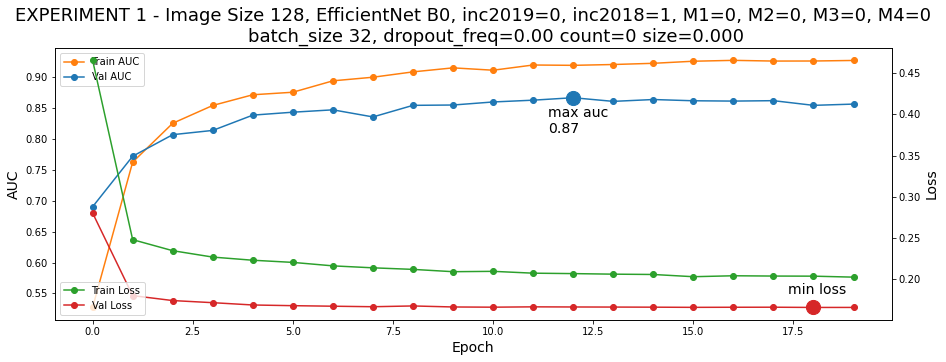

#########################
#### EXPERIMENT 2
#### Image Size 128 with EfficientNet B0, batch_size 32, dropout_freq=0.75 count=8 size=0.200
#### Using 2018+2017 external data
#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### EXPERIMENT 2 OOF AUC without TTA = 0.887, with TTA = 0.898


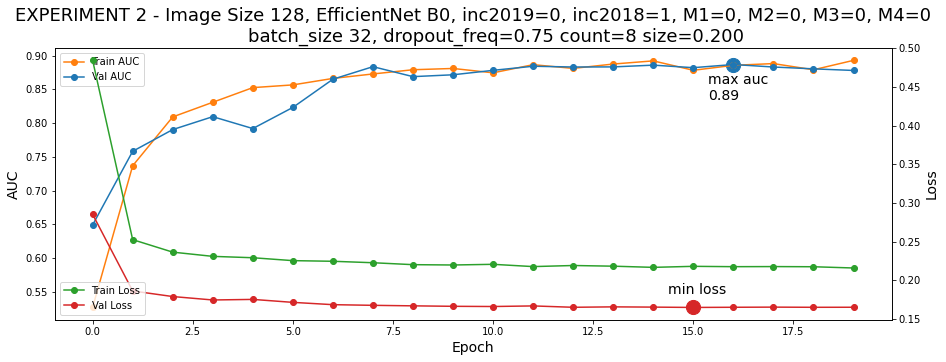

#########################
#### EXPERIMENT 3
#### Image Size 128 with EfficientNet B0, batch_size 32, dropout_freq=0.75 count=8 size=0.200
#### Using 2018+2017 external data
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-2 data (ISIC website)
#### Upsample MALIG-3 data (2019 comp)
#### Upsample MALIG-4 data (2018 2017 comp)
#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### EXPERIMENT 3 OOF AUC without TTA = 0.895, with TTA = 0.905


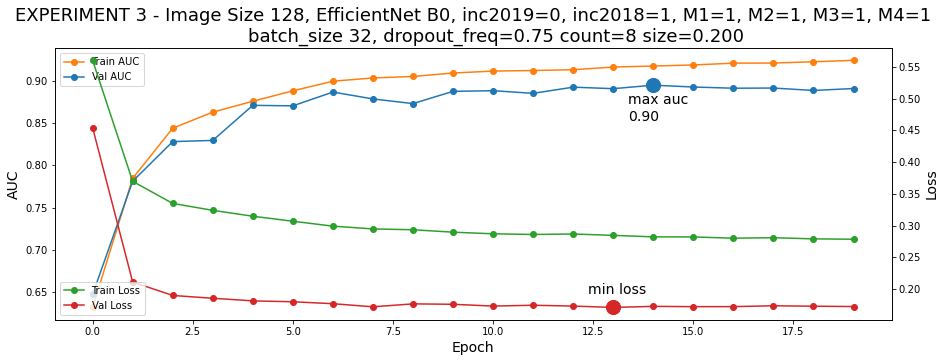

In [14]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 0
DISPLAY_PLOT = True

oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

for fold in range(EXPERIMENTS):
    # REPEAT SAME FOLD OVER AND OVER
    idxT = idxTT
    idxV = idxVV
    
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### EXPERIMENT',fold+1)
    print('#### Image Size %i with EfficientNet B%i, batch_size %i, dropout_freq=%.2f count=%i size=%.3f'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS,
           DROP_FREQ[fold],DROP_CT[fold],DROP_SIZE[fold]))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    for k in range(M1[fold]):
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT])
        print('#### Upsample MALIG-1 data (2020 comp)')
    for k in range(M2[fold]):
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT+15])
        print('#### Upsample MALIG-2 data (ISIC website)')
    for k in range(M3[fold]):
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1+30])
        print('#### Upsample MALIG-3 data (2019 comp)')
    for k in range(M4[fold]):
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+30])
        print('#### Upsample MALIG-4 data (2018 2017 comp)')
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
   
    # TRAIN
    print('Training...')
    history = model.fit(
        get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold],
                droprate=DROP_FREQ[fold], dropct=DROP_CT[fold], dropsize=DROP_SIZE[fold]), 
        epochs=EPOCHS[fold], callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])], 
        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                repeat=False,dim=IMG_SIZES[fold]), #class_weight = {0:1,1:2},
        verbose=VERBOSE
    )
    
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2,
            droprate=DROP_FREQ[fold], dropct=DROP_CT[fold], dropsize=DROP_SIZE[fold])
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/2/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    if INFER_TEST:
        print('Predicting Test with TTA...')
        ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2,
            droprate=DROP_FREQ[fold], dropct=DROP_CT[fold], dropsize=DROP_SIZE[fold])
        ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/2/REPLICAS
        pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
        preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### EXPERIMENT %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('EXPERIMENT %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i, M1=%i, M2=%i, M3=%i, M4=%i\n\
        batch_size %i, dropout_freq=%.2f count=%i size=%.3f'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold],M1[fold],M2[fold],M3[fold],
                 M4[fold],BATCH_SIZES[fold]*REPLICAS,DROP_FREQ[fold],DROP_CT[fold],DROP_SIZE[fold]),size=18)
        plt.legend(loc=3)
        plt.show()  
        
    del model; z = gc.collect()

## Save OOF Preds
The OOF (out of fold) predictions are saved to disk. If you wish to ensemble multiple models, use the OOF to determine what are the best weights to blend your models with. Choose weights that maximize OOF CV score when used to blend OOF. Then use those same weights to blend your test predictions.

In [15]:
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof.csv',index=False)
df_oof.head()

,image_name,target,pred,fold
0,ISIC_0074311,0,0.038076,0
1,ISIC_0088137,0,0.023506,0
2,ISIC_0081956,0,0.022165,0
3,ISIC_0091996,0,0.065838,0
4,ISIC_0084270,0,0.033500,0


# Submit To Kaggle
If we chose to predict by setting `INFER_TEST = True` above, then we create `submission.csv` here.

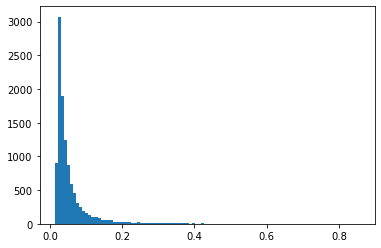

In [16]:
if INFER_TEST:
    ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

    image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

    submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
    submission = submission.sort_values('image_name') 
    submission.to_csv('submission.csv', index=False)
    submission.head()

    plt.hist(submission.target,bins=100)
    plt.show()
else:
    print('We did not predict test set')